In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda, u_met
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (30., 30.)
#%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
pdf = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))

In [4]:
pdf_march = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=10) &
(pdf.month == 3) & (pdf.year >=2000) & (pdf.year <=2012))
pdf_march = pdf_march.dropna()

In [5]:
pdf_oct = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=10) &
(pdf.month == 10) & (pdf.year >=2000) & (pdf.year <=2012))
pdf_oct = pdf_oct.dropna()

In [6]:
era_srfc = xr.open_dataset(cnst.ERA5_MONTHLY_SRFC_SYNOP)
era_pl = xr.open_dataset(cnst.ERA5_MONTHLY_PL_SYNOP)

In [7]:
era_pl = uda.flip_lat(era_pl)
era_srfc = uda.flip_lat(era_srfc)

In [51]:
era_pl.time

<xarray.DataArray 'time' (time: 3864)>
array(['1979-01-01T00:00:00.000000000', '1979-01-01T03:00:00.000000000',
       '1979-01-01T06:00:00.000000000', ..., '2019-03-01T15:00:00.000000000',
       '2019-03-01T18:00:00.000000000', '2019-03-01T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2019-03-01T21:00:00
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T

In [316]:
chirps = xr.open_mfdataset(cnst.CHIRPS_MONTHLY + "*.nc", concat_dim='time',autoclose=True)
chirps = uda.flip_lat(chirps)
chov = chirps.sel(lat=slice(4,15), lon=slice(-10,10)).groupby('time.month').mean('time').mean('lon')

In [317]:
ar = xr.open_dataarray(cnst.GRIDSAT + 'aggs/WAbox_meanT-50_hov_5000km2.nc')
mean = ar.mean('year')
ar70 = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-70_monthly_mean_5000km2.nc')
ar70 = ar70['tir'].sel(lon=slice(-10,10), lat=slice(4,15)).groupby('time.month').mean('time').mean('lon')

In [318]:
OBS2 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_ERA-I.p', 'rb'))
def create_dic(dic):
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])
    umax = np.array(dic['u925'])
    qq = np.array(dic['q925']) 
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])

    obs_pcp = {
        'prcp' : pp,
        'u650' : umin,
        'u925' : umax,
        'q925' : qq*1000,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
    } 
    obs = pd.DataFrame(obs_pcp)
    return obs
obs_gpm = create_dic(OBS2)

In [319]:
obs_gpm.lat.max()
obs_gpm.lat.min()

4.730003217123114

In [320]:
obs_gpm = obs_gpm[(obs_gpm.lon>=-10)&(obs_gpm.lon<=10)]

In [321]:
lats = np.arange(4.5,9,0.5)
dic = {3 : [], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[]}
dic_mean = {3 : [], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[]}
dic_abs = {3 : [], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[]}
gpmlist = []
for k in dic.keys():
    for ids, ll in enumerate(lats[0:-2]):
        print('between', ll, lats[ids+1])
        storms = obs_gpm[(obs_gpm.lat>=ll)&(obs_gpm.lon<=lats[ids+1])&(obs_gpm.month==k)]
        summi = np.sum((storms['prcp']>50))/np.sum((storms['prcp']>0))
        dic[k].append(summi)
        dic_mean[k].append(np.sum((storms['prcp']>0)))
        dic_abs[k].append(np.sum((storms['prcp']>50)))
latbin = lats[1:-1]-0.25

between 4.5 5.0
between 5.0 5.5
between 5.5 6.0
between 6.0 6.5
between 6.5 7.0
between 7.0 7.5
between 7.5 8.0
between 4.5 5.0
between 5.0 5.5
between 5.5 6.0
between 6.0 6.5
between 6.5 7.0
between 7.0 7.5
between 7.5 8.0
between 4.5 5.0
between 5.0 5.5
between 5.5 6.0
between 6.0 6.5
between 6.5 7.0
between 7.0 7.5
between 7.5 8.0
between 4.5 5.0
between 5.0 5.5
between 5.5 6.0
between 6.0 6.5
between 6.5 7.0
between 7.0 7.5
between 7.5 8.0
between 4.5 5.0
between 5.0 5.5
between 5.5 6.0
between 6.0 6.5
between 6.5 7.0
between 7.0 7.5
between 7.5 8.0
between 4.5 5.0
between 5.0 5.5
between 5.5 6.0
between 6.0 6.5
between 6.5 7.0
between 7.0 7.5
between 7.5 8.0
between 4.5 5.0
between 5.0 5.5
between 5.5 6.0
between 6.0 6.5
between 6.5 7.0
between 7.0 7.5
between 7.5 8.0
between 4.5 5.0
between 5.0 5.5
between 5.5 6.0
between 6.0 6.5
between 6.5 7.0
between 7.0 7.5
between 7.5 8.0
between 4.5 5.0
between 5.0 5.5
between 5.5 6.0
between 6.0 6.5
between 6.5 7.0
between 7.0 7.5
between 

In [322]:
len(dic[6])

7

In [323]:
len(latbin)

7

In [324]:
## a clean way of plotting - use matplotlib functions directly:

def draw_cross(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, **kwargs, extend='both')  # this is the actual plot
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'], width=0.002)
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        plt.clabel(cs, inline=1, fontsize=10)
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)


In [325]:
era_pl['ymonth'] = ('time', [str(m)+'-'+str(h) for (m,h) in zip(era_pl['time.month'].values,era_pl['time.hour'].values)])
grouped='ymonth'
era_pl_cross =  era_pl.groupby(grouped).mean(dim='time')

In [332]:
era_srfc['ymonth'] = ('time', [str(m)+'-'+str(h) for (m,h) in zip(era_srfc['time.month'].values,era_srfc['time.hour'].values)])
grouped='ymonth'
era_srfc_cross =  era_srfc.groupby(grouped).mean(dim='time')

/home/ck/miniconda3/lib/python3.5/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [327]:
cross_meanT_march

<xarray.DataArray (lat: 221)>
array([-61.830566, -61.958042, -62.190807, ..., -55.439182, -55.040844,
       -54.705025], dtype=float32)
Coordinates:
    month    int64 5
  * lat      (lat) float32 4.550003 4.6200027 4.6900024 ... 19.879997 19.949997

In [352]:
m1 = 5
m2 = 10
cross_march = era_pl_cross.sel(ymonth=str(m1)+'-12', longitude=slice(-10,10), latitude=slice(3,15))
cross_oct = era_pl_cross.sel(ymonth=str(m2)+'-12', longitude=slice(-10,10), latitude=slice(3,15))
cross_marchs = era_srfc_cross.sel(ymonth=str(m1)+'-12', longitude=slice(-10,10), latitude=slice(3,15))
cross_octs = era_srfc_cross.sel(ymonth=str(m2)+'-12', longitude=slice(-10,10), latitude=slice(3,15))
cross_m_shear = cross_march.mean('longitude').sel(level=650)-cross_march.mean('longitude').sel(level=900)
cross_o_shear = cross_oct.mean('longitude').sel(level=650)-cross_march.mean('longitude').sel(level=900)
cross_prcp_march = chov.sel(month=m1)
cross_prcp_oct = chov.sel(month=m2)
cross_meanT_march = mean.sel(month=m1)
cross_meanT_oct = mean.sel(month=m2)
cross_70_march = ar70.sel(month=m1)
cross_70_oct = ar70.sel(month=m2)
ext_frac_m = dic[m1]
ext_frac_o = dic[m2]
ext_mean_m = dic_mean[m1]
ext_mean_o = dic_mean[m2]
ext_abs_m = dic_abs[m1]
ext_abs_o = dic_abs[m2]

In [348]:
cross_marchs

<xarray.Dataset>
Dimensions:    (latitude: 17, longitude: 28)
Coordinates:
  * longitude  (longitude) float32 -9.4 -8.7 -8.0 -7.3 -6.6 ... 7.4 8.1 8.8 9.5
  * latitude   (latitude) float32 3.5 4.2 4.9 5.6 6.3 ... 12.6 13.3 14.0 14.7
    ymonth     <U4 '4-12'
Data variables:
    u100       (latitude, longitude) float32 0.23394409 0.37894604 ... -3.786731
    v100       (latitude, longitude) float32 2.116609 2.1420615 ... -1.4371927
    u10        (latitude, longitude) float32 0.22593279 0.3571256 ... -3.198987
    v10        (latitude, longitude) float32 2.0074859 2.019481 ... -1.2602224
    d2m        (latitude, longitude) float32 296.9002 296.91574 ... 273.03082
    t2m        (latitude, longitude) float32 300.37558 300.42755 ... 311.13474
    blh        (latitude, longitude) float32 483.07526 491.93622 ... 2278.607
    cape       (latitude, longitude) float32 719.5262 741.3499 ... 10.240451
    cin        (latitude, longitude) float32 91.65181 91.26077 ... nan nan
    hcc        (lat

In [349]:
ccross_march = cross_march.mean('longitude')
ccross_oct = cross_oct.mean('longitude')

/home/ck/miniconda3/lib/python3.5/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.5/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


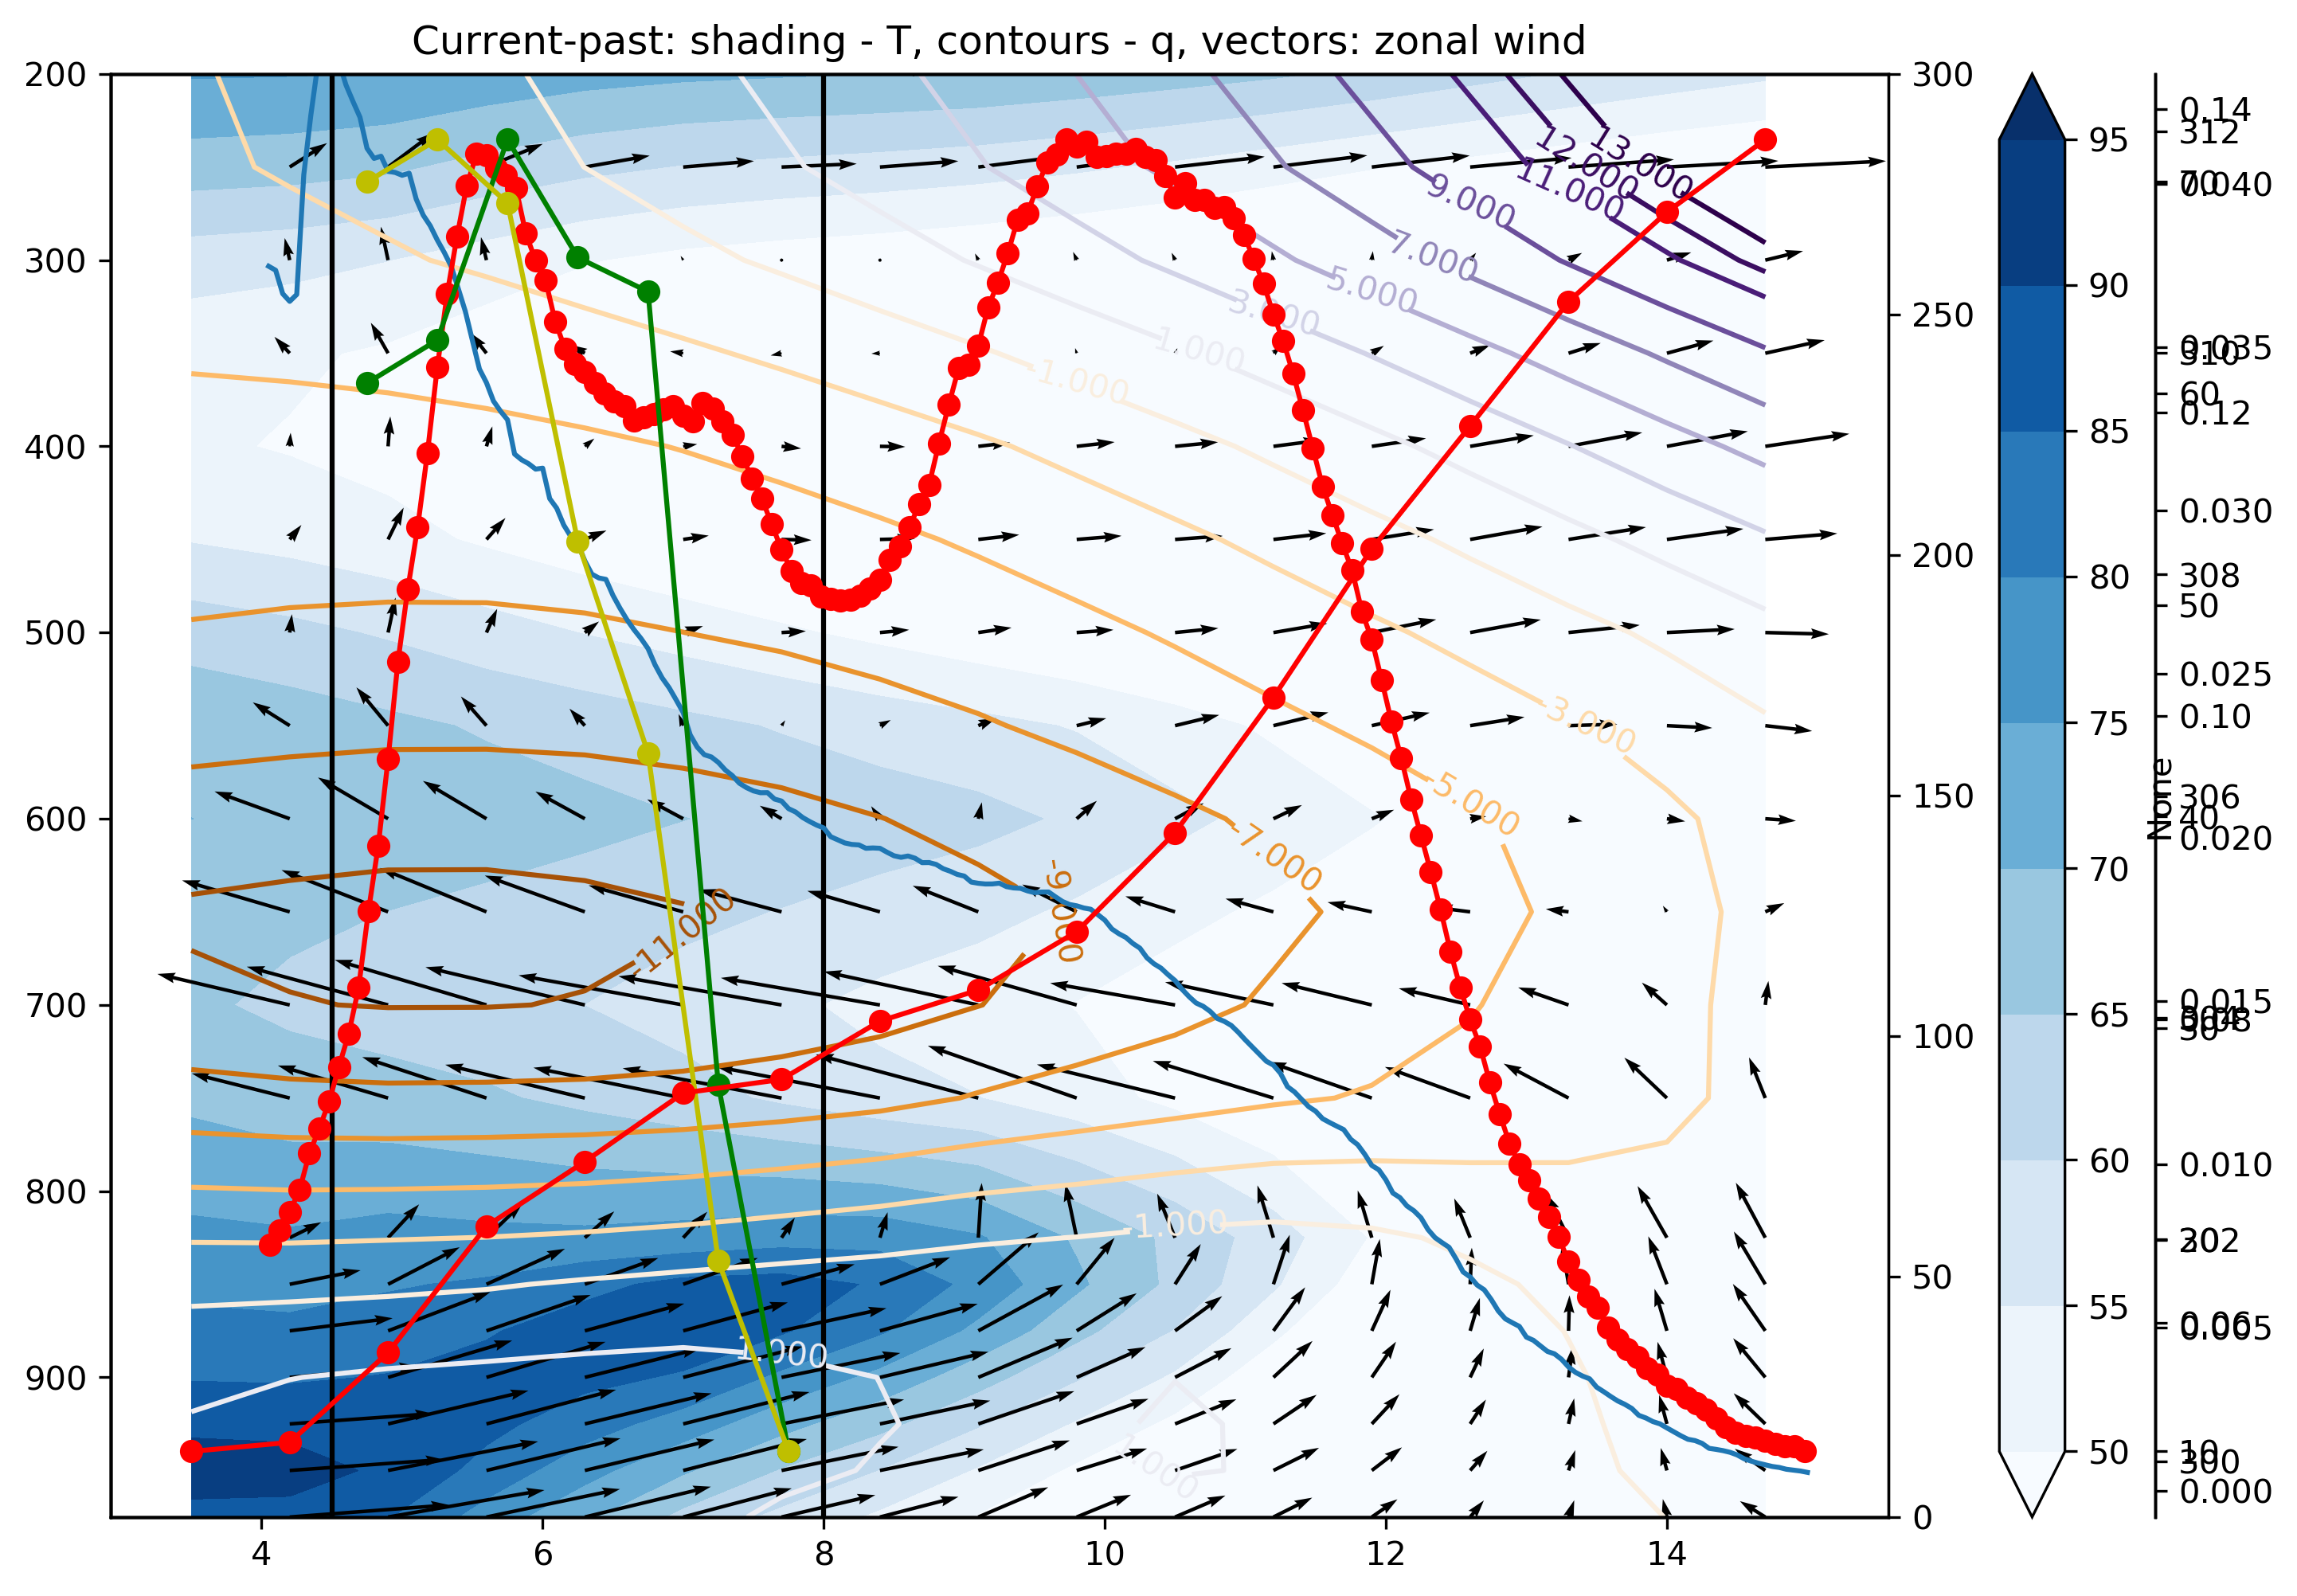

In [353]:

f=plt.figure(figsize=(12,8), dpi=300)  # this opens a plot window

ax = f.add_subplot(111)

# "current zonal wind" wind vectors
vano = ccross_march['v']
wano = ccross_march['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
st=1
sarrow = 1
xquiv = ccross_march.latitude[sarrow::st]
yquiv = ccross_march.level

uu = (vano)[::, sarrow::st]  
ww = (wano)[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 30}

# temperature and moisture check
data = (ccross_march['u'])
data2 = ccross_march['r']
contour = {'data' : data, 'x' : ccross_oct.latitude, 'y' : ccross_oct.level, 'levels' : [-13,-12,-11,-9,-7,-5,-3,-1,1,3,5,7,9,11,12,13], 'cmap' : 'PuOr'}
draw_cross(ax, data2, ccross_oct.latitude, ccross_oct.level, cmap='Blues', 
           levels=np.arange(50,100,5), quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')


plt.axvline(x=4.5, color='k')
plt.axvline(x=8, color='k')

ax1 = ax.twinx()
ax1.plot(cross_prcp_march.lat, cross_prcp_march['precip'].values)
ax1.set_ylim(0,300)

ax2 = ax.twinx()
ax2.spines["right"].set_position(("axes", 1.15))
ax2.plot(cross_70_march.lat,cross_70_march.values, '-ro')

ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.15))
ax3.plot(latbin,ext_frac_m, '-go')

ax4 = ax.twinx()
ax4.spines["right"].set_position(("axes", 1.15))
ax4.plot(latbin,ext_abs_m, '-yo')

ax4 = ax.twinx()
ax4.spines["right"].set_position(("axes", 1.15))
ax4.plot(cross_marchs.latitude,cross_marchs['t2m'].mean('longitude').values, '-ro')

/home/ck/miniconda3/lib/python3.5/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ck/miniconda3/lib/python3.5/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


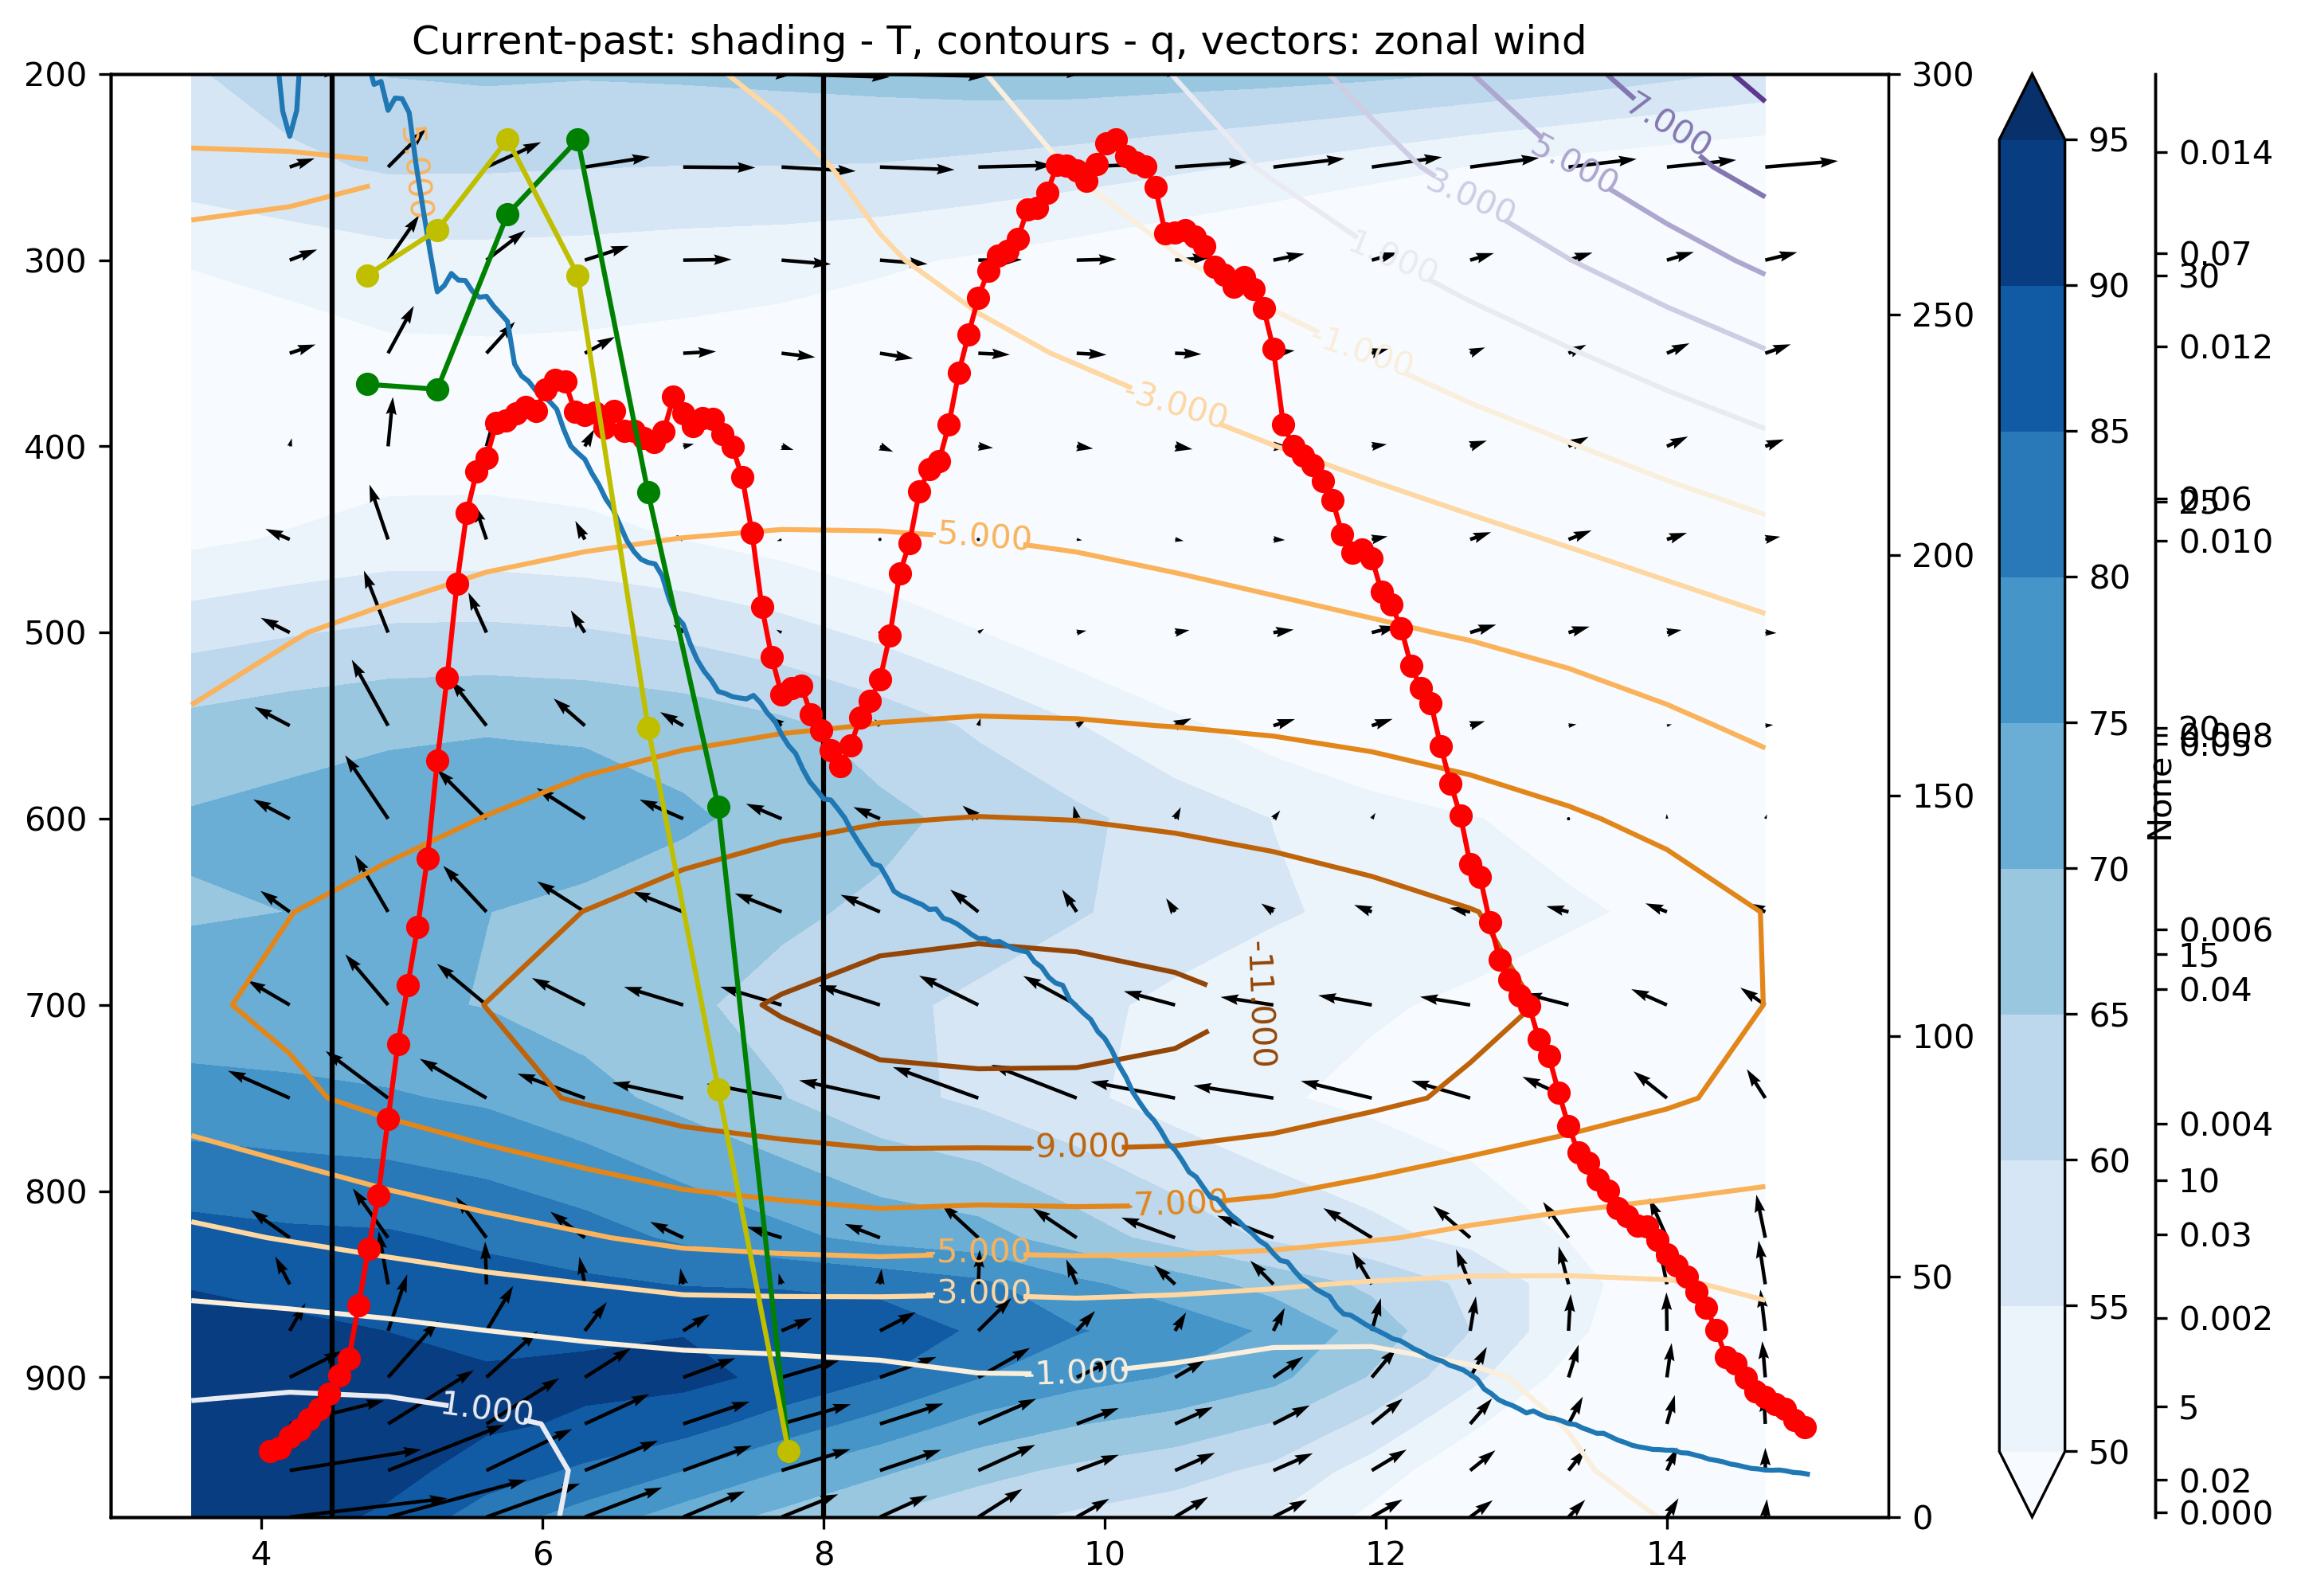

In [351]:

f=plt.figure(figsize=(12,8), dpi=300)  # this opens a plot window

ax = f.add_subplot(111)

# "current zonal wind" wind vectors
vano = ccross_oct['v']
wano = ccross_oct['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
st=1
sarrow = 1
xquiv = ccross_oct.latitude[sarrow::st]
yquiv = ccross_oct.level

uu = (vano)[::, sarrow::st]  
ww = (wano)[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 30}

# temperature and moisture check
data = (ccross_oct['u'])
data2 = ccross_oct['r']
contour = {'data' : data, 'x' : ccross_oct.latitude, 'y' : ccross_oct.level, 'levels' : [-12,-11,-9,-7,-5,-3,-1,1,3,5,7,9,11,12], 'cmap' : 'PuOr'}
draw_cross(ax, data2, ccross_oct.latitude, ccross_oct.level, cmap='Blues', 
           levels=np.arange(50,100,5), quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')


plt.axvline(x=4.5, color='k')
plt.axvline(x=8, color='k')

ax1 = ax.twinx()
ax1.plot(cross_prcp_oct.lat, cross_prcp_oct['precip'].values)
ax1.set_ylim(0,300)

ax2 = ax.twinx()
ax2.spines["right"].set_position(("axes", 1.15))
ax2.plot(cross_70_oct.lat,cross_70_oct.values, '-ro')

ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.15))
ax3.plot(latbin,ext_frac_o, '-go')

ax4 = ax.twinx()
ax4.spines["right"].set_position(("axes", 1.15))
ax4.plot(latbin,ext_abs_o, '-yo')

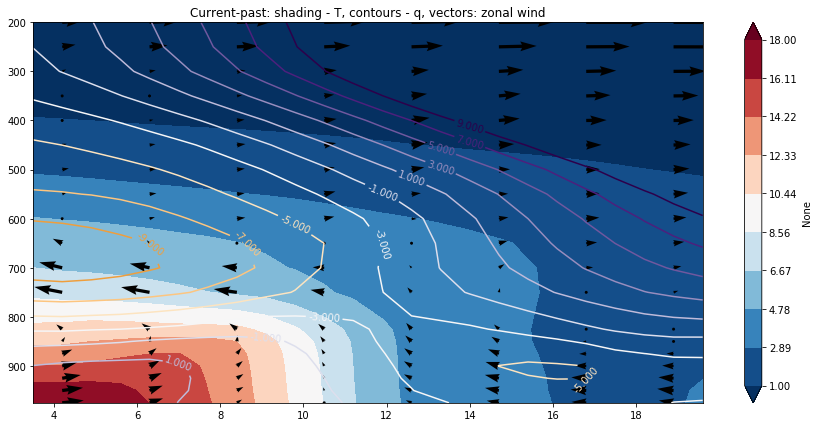

In [108]:
# "current zonal wind" wind vectors
uano = ccross_march['u']
wano = ccross_march['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
vano = ccross_march['v']
st=3
sarrow = 1
xquiv = ccross_march.latitude[sarrow::st]
yquiv = ccross_march.level

uu = (vano)[::, sarrow::st]  
ww = (wano)[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 80}

# temperature and moisture check
data = (ccross_march['u'])
data2 = ccross_march['q'].values*1000
contour = {'data' : data, 'x' : ccross_march.latitude, 'y' : ccross_march.level, 'levels' : np.arange(-15,10,2), 'cmap' : 'PuOr'}
draw_cross(data2, ccross_march.latitude, ccross_march.level, cmap='RdBu_r', 
           levels=np.linspace(1,18,10), quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')

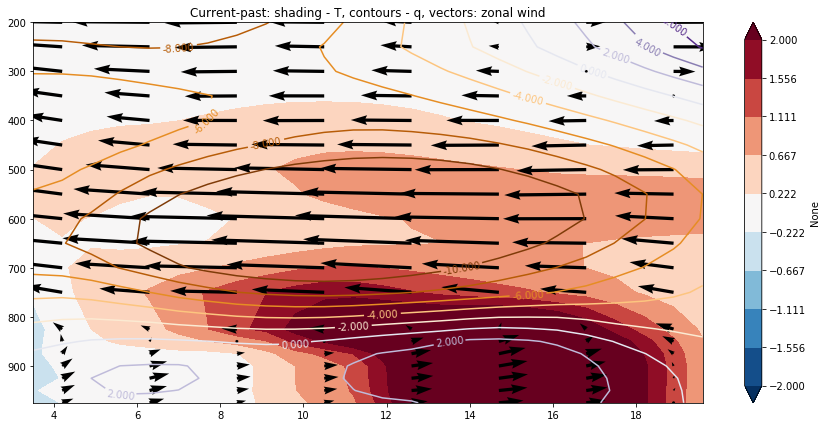

In [88]:
# "current zonal wind" wind vectors
uano = ccross_march['u']
wano = ccross_march['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
st=3
sarrow = 1
xquiv = ccross_march.latitude[sarrow::st]
yquiv = ccross_march.level

uu = (uano)[::, sarrow::st]  
ww = (wano)[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 80}

# temperature and moisture check
data = (ccross_march['u'])#-ccross_oct['u'])
contour = {'data' : data, 'x' : ccross_march.latitude, 'y' : ccross_march.level, 'levels' : np.arange(-10,10,2), 'cmap' : 'PuOr'}
draw_cross((ccross_march['q']-ccross_oct['q'])*1000, ccross_march.latitude, ccross_march.level, cmap='RdBu_r', 
           levels=np.linspace(-2,2,10), quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')

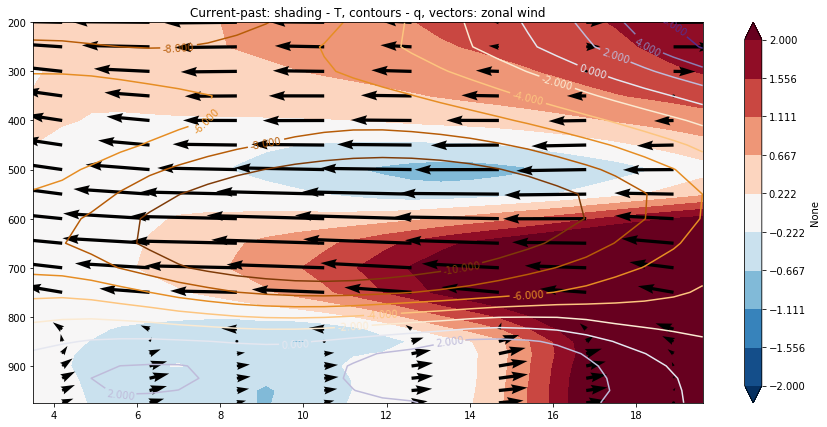

In [89]:
# "current zonal wind" wind vectors
uano = ccross_march['u']
wano = ccross_march['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
st=3
sarrow = 1
xquiv = ccross_march.latitude[sarrow::st]
yquiv = ccross_march.level

uu = (uano)[::, sarrow::st]  
ww = (wano)[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 80}

# temperature and moisture check
data = (ccross_march['u'])#-ccross_oct['u'])
contour = {'data' : data, 'x' : ccross_march.latitude, 'y' : ccross_march.level, 'levels' : np.arange(-10,10,2), 'cmap' : 'PuOr'}
draw_cross((ccross_march['t']-ccross_oct['t']), ccross_march.latitude, ccross_march.level, cmap='RdBu_r', 
           levels=np.linspace(-2,2,10), quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')

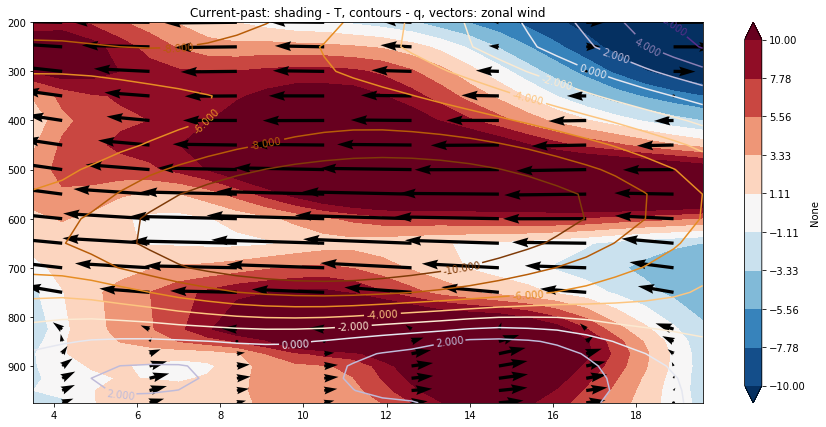

In [90]:
# "current zonal wind" wind vectors
uano = ccross_march['u']
wano = ccross_march['w']*(-10)  # multiplied by 10 since vertical component is very small compared to horizontal one
st=3
sarrow = 1
xquiv = ccross_march.latitude[sarrow::st]
yquiv = ccross_march.level

uu = (uano)[::, sarrow::st]  
ww = (wano)[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 80}

# temperature and moisture check
data = (ccross_march['u'])#-ccross_oct['u'])
contour = {'data' : data, 'x' : ccross_march.latitude, 'y' : ccross_march.level, 'levels' : np.arange(-10,10,2), 'cmap' : 'PuOr'}
draw_cross((ccross_march['r']-ccross_oct['r']), ccross_march.latitude, ccross_march.level, cmap='RdBu_r', 
           levels=np.linspace(-10,10,10), quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')

In [91]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show()   

In [92]:
(cross_march)['u']

<xarray.DataArray 'u' (level: 19, latitude: 24, longitude: 28)>
array([[[-8.069738, -8.224792, ..., -8.230613, -8.491058],
        [-8.210897, -8.392236, ..., -8.531927, -8.496091],
        ...,
        [ 8.082482,  7.885376, ...,  4.856769,  4.743877],
        [ 9.5239  ,  9.312158, ...,  6.169141,  6.039056]],

       [[-7.821549, -7.815914, ..., -7.042694, -7.23189 ],
        [-7.882095, -7.882109, ..., -7.17167 , -7.388426],
        ...,
        [ 6.544526,  6.422909, ...,  4.237119,  4.113498],
        [ 7.799982,  7.648923, ...,  5.356267,  5.222041]],

       ...,

       [[-0.799539, -0.630063, ...,  0.89372 ,  2.146788],
        [-0.248028, -0.106313, ...,  1.905762,  0.567144],
        ...,
        [-2.042431, -1.726182, ..., -2.115082, -2.628687],
        [-2.093946, -1.837738, ..., -2.6438  , -1.629503]],

       [[-0.84399 , -0.656974, ...,  0.481354,  2.169719],
        [-0.372831, -0.234387, ...,  1.854622, -0.048761],
        ...,
        [-1.65006 , -1.379098, ..., -2.

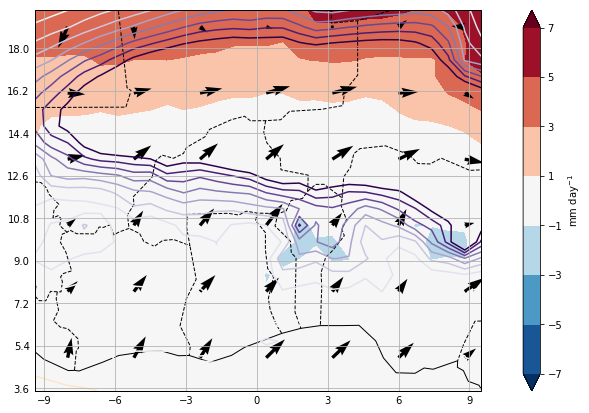

In [93]:
lon=cross_march.longitude
lat=cross_march.latitude
map_cross_march = cross_march.sel(level=925)
map_cross_oct = cross_oct.sel(level=925)
data=map_cross_march['t']-map_cross_oct['t']
data2=map_cross_march['q']-map_cross_oct['q']
title=''

contour = {'data' : data2*1000, 'x' : lon, 'y' : lat, 'levels' : np.arange(-3,3,0.4), 'cmap' : 'PuOr'}

# preparation of wind vector data in plot
st=4
sarrow = 2
xquiv = map_cross_march.longitude[sarrow::st]
yquiv = map_cross_march.latitude[sarrow::st]

uu = (map_cross_march['u'])[sarrow::st, sarrow::st]
vv = (map_cross_march['v'])[sarrow::st, sarrow::st]


qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : 70}

draw_map(data, lon, lat, title=title, levels=np.linspace(-7,7,8), extend='both', quiver=qin, cmap='RdBu_r', contour=contour, cbar_label= 'mm day$^{-1}$')


In [55]:
def linear_trend_lingress_2d(x, nb_missing=None, sig=None, method=None):
    
    
    # stack lat and lon into a single dimension called allpoints
    datastacked = x.stack(allpoints=['latitude', 'level'])

    # apply the function over allpoints to calculate the trend at each point
    print('Entering trend calc')

    alpha = 0.05
    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='mk':
        dtrend = datastacked.groupby('allpoints').apply(uda.linear_trend_mk, alpha=alpha, eps=0.0001,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')
        if sig:
            (dtrend['slope'].values)[dtrend['ind'].values==0] = 0

    # NaNs means there is not enough data, slope = 0 means there is no significant trend.
    if method=='polyfit':
        dtrend = datastacked.groupby('allpoints').apply(uda.linear_trend_lingress,nb_missing=10)
        dtrend = dtrend.unstack('allpoints')

        if sig:
            (dtrend['slope'].values)[dtrend['pval'].values > alpha] = np.nan
            
    return dtrend['slope']

In [87]:
era_srfc = xr.open_dataset(cnst.ERA_MONTHLY_SRFC)
era_pl = xr.open_dataset(cnst.ERA_MONTHLY_PL)
ccover = xr.open_dataset(cnst.GRIDSAT + 'aggs/gridsat_WA_-70_monthly_count.nc')
era_srfc = uda.flip_lat(era_srfc)
era_pl = uda.flip_lat(era_pl)
era_trend = era_pl.sel(longitude=slice(-10,10), latitude=slice(4,20), level=slice(200,925)).squeeze().mean('longitude')

In [88]:
def trends_month(var):
    
    utrend = (era_trend[var])[(era_trend['time.year']>1982)].groupby('time.month').apply(linear_trend_lingress_2d,nb_missing=10, method='mk')*10
    
    return utrend

In [89]:
utrend = trends_month('t')

Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc
Entering trend calc


In [93]:
ccross_march = cross_march.mean('longitude')
ccross_oct = cross_oct.mean('longitude')
ccross_march['t'].values = u_met.theta(ccross_march.level.values, ccross_march['t'].values-273.15)

In [94]:
utrend

<xarray.DataArray 'slope' (month: 12, level: 16, latitude: 21)>
array([[[ 1.328607e-01,  1.356456e-01, ...,  2.368253e-01,  2.498322e-01],
        [ 3.110963e-01,  3.133256e-01, ...,  3.579069e-01,  3.476832e-01],
        ...,
        [ 1.650719e-01,  1.477577e-01, ..., -1.268864e-02,  4.659957e-03],
        [ 1.862761e-01,  1.760384e-01, ...,  2.098806e-02,  4.814793e-02]],

       [[ 1.300725e-01,  1.377932e-01, ...,  4.305631e-01,  4.422398e-01],
        [ 3.375626e-01,  3.387907e-01, ...,  5.484644e-01,  5.626476e-01],
        ...,
        [ 1.474275e-01,  1.059498e-01, ...,  1.559635e-01,  1.388612e-01],
        [ 1.487389e-01,  1.103346e-01, ...,  1.426760e-01,  1.295491e-01]],

       ...,

       [[ 1.850886e-01,  1.903404e-01, ...,  2.912965e-01,  2.916931e-01],
        [ 3.915500e-01,  3.988353e-01, ...,  4.018814e-01,  3.945066e-01],
        ...,
        [ 1.525678e-01,  1.374463e-01, ...,  1.052315e-01,  1.016694e-01],
        [ 1.635867e-01,  1.574396e-01, ...,  1.044042e-

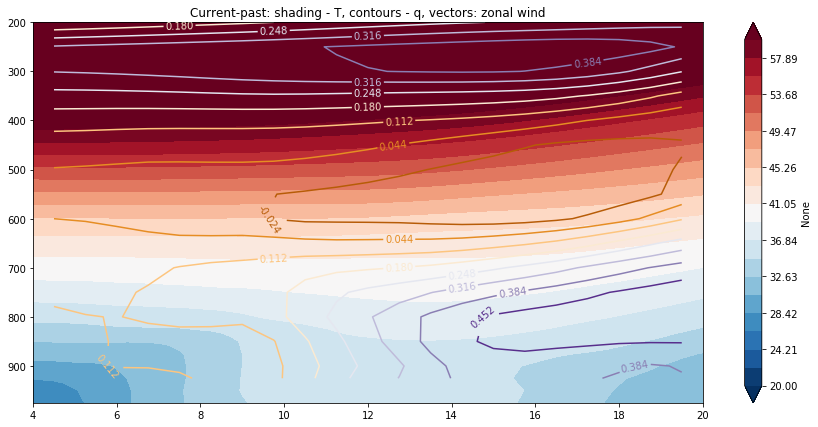

In [95]:
# temperature and moisture check
data = utrend.sel(month=3) #(ccross_march['t'])
contour = {'data' : data, 'x' : utrend.latitude, 'y' : utrend.level, 'levels' : np.linspace(data.min(),data.max(),10), 'cmap' : 'PuOr'}
draw_cross((ccross_march['t']), ccross_march.latitude, ccross_march.level, cmap='RdBu_r', contour=contour,
           levels=np.linspace(20,60,20), title='Current-past: shading - T, contours - q, vectors: zonal wind')